### Fitting an HMM using Deterministic Annealing EM (DAEM)

This notebook is designed to introduce users to the concept of deterministic annealing expectation maximization, or DAEM (for more information, see [Ueda and Nakano 1998](https://www.sciencedirect.com/science/article/pii/S0893608097001330)). We recommend walking through this notebook after first becoming familiar with the procedures outlined in the basic HMM fitting notebook. 

DAEM is primarily useful for data that is difficult to fit and for which finding the global optimum is challenging. In short, this method applies a temperature parameter $B$ to the posterior, starting at a low value ($B<1$). This temperature parameter weakens the influence of the posterior at early stages of training, when it tends to be unreliable. After convergence of EM, the estimates of the fitted parameters then become initial parameter values (presumably closer to the correct parameter values than random initializations) for a second round of EM. In this second round, $B$ is moderately increased in order to strengthen the effect of the posterior. This process continues iteratively, with $B$ increasing in each round of EM by a pre-specified step size until $B=1$. Although this method can take longer than traditional EM, it leads to more consistent estimates of the log-likelihood that match the global optimum and are less sensitive to initialization.

<b>Note:</b> This notebook takes a not short amount of time to run. We recommend reading through it in its entirety first, examining the outputs, and making sure you understand what is happening. Then if you'd like to tweak things and run it yourself, go for it, but go eat a snack and have a chat with a friend in the meantime. <i>(If you'd like to try to make it run faster, reduce the values of N, K, C, and inits.)</i>

#### 1. Import the required code packages and modules.

In [8]:
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
import numpy as np
import time
from glmhmm import hmm
from glmhmm.utils import permute_states, find_best_fit
from glmhmm.visualize import plot_model_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2. Set the hyper-parameters of the HMM

In [9]:
N = 80000 # number of data/time points
K = 4 # number of latent states
C = 3 # number of observation classes

#### 3. Instantiate the model and generate true parameters.

In [10]:
true_HMM = hmm.HMM(N,0,C,K) # D = 0 because there are no inputs (no GLM component)
A_true,phi_true,pi_true = true_HMM.generate_params(emissions=['dirichlet',3,1],state_priors='normal')

#### 4. Given the true parameters, generate some data. 

In [11]:
true_y,true_z = true_HMM.generate_data(A_true,phi_true,pi0=pi_true)

#### 5. Fit the model using traditional EM.

In [44]:
inits = 10 # specify number of initializations to run

# store the parameter values from each initialization
lls_EM = np.zeros((inits,250)) # 250 is the default number of maximum iterations of EM
A_EM = np.zeros((inits,K,K))
phi_EM = np.zeros((inits,K,C))
pi_EM = np.zeros((inits,K))

# we'll save the initializations too, so we can use the same ones when comparing to DAEM
A_inits = np.zeros((inits,K,K))
phi_inits = np.zeros((inits,K,C))
pi_inits = np.zeros((inits,K,1))
for i in range(inits):
    A_init,phi_init,pi_init = true_HMM.generate_params()
    A_inits[i,:,:] = A_init
    phi_inits[i,:,:] = phi_init
    pi_inits[i,:] = pi_init
    lls_EM[i,:],A_EM[i,:,:],phi_EM[i,:,:],pi_EM[i] = true_HMM.fit(true_y,A_init,phi_init,pi0=pi_init,fit_init_states=True)
    print('initialization %s complete' %(i+1))

initialization 1 complete
initialization 2 complete
initialization 3 complete
initialization 4 complete
initialization 5 complete
initialization 6 complete
initialization 7 complete
initialization 8 complete
initialization 9 complete
initialization 10 complete


#### 7. Now fit the model using deterministic annealing EM (DAEM).

In [53]:
# fit model for range of temperature parameters
Bs = [0.7,0.8,0.9,1.0]

inits = 10

# store the parameter values from each initialization
lls_DAEM = np.zeros((inits,250))
A_DAEM = np.zeros((inits,K,K))
phi_DAEM = np.zeros((inits,K,C))
pi_DAEM = np.zeros((inits,K))

for i in range(inits):
    A_init, phi_init, pi_init = A_inits[i,:,:],phi_inits[i,:,:],pi_inits[i,:]
    for B in Bs:
        if B < 1.0:
            _,A_init,phi_init,pi_init = true_HMM.fit(true_y,A_init,phi_init,pi0=pi_init,fit_init_states=True,B=B) # fit with given temperature parameter 'B'
        else:
            lls_DAEM[i,:],A_DAEM[i,:,:],phi_DAEM[i,:,:],pi_DAEM[i] = true_HMM.fit(true_y,A_init,phi_init,pi0=pi_init,fit_init_states=True,B=B) # fit with given temperature parameter 'B'
        #print('EM with B=%s complete' %(B))
    print('initialization %s complete' %(i+1))

initialization 1 complete
initialization 2 complete
initialization 3 complete
initialization 4 complete
initialization 5 complete
initialization 6 complete
initialization 7 complete
initialization 8 complete
initialization 9 complete
initialization 10 complete


Text(0, 0.5, 'loglikelihood')

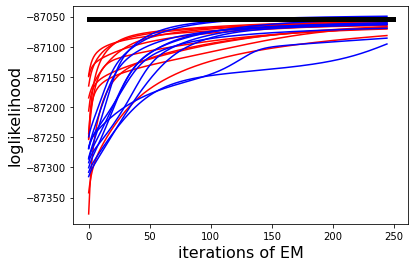

In [57]:
true_ll,_,_ = true_HMM.forwardPass(true_y,A_true,phi_true,pi0=pi_true)

plt.plot(lls_EM.T[5:], color='red')
plt.plot(lls_DAEM.T[5:], color='blue')
plt.plot(np.ones(250)*true_ll,color='black',linewidth=5)
plt.xlabel('iterations of EM',fontsize=16)
plt.ylabel('loglikelihood',fontsize=16)

Note how the log-likelihoods from the DAEM fits (blue) start at a higher value than the EM fits (red). This is a result of the deterministic annealing process, which learns better initializations as $B$ increases.

Text(0, 0.5, '# of fits')

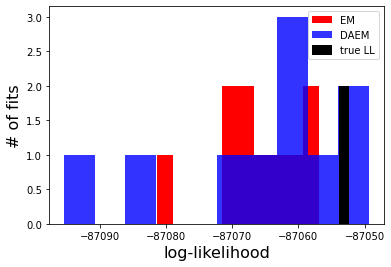

In [56]:
final_lls_EM = np.array([np.amax(lls_EM[i,~np.isnan(lls_EM[i,:])]) for i in range(inits)])
final_lls_DAEM = np.array([np.amax(lls_DAEM[i,~np.isnan(lls_DAEM[i,:])]) for i in range(inits)])

plt.hist(final_lls_EM,bins=10,color='red',label='EM')
plt.hist(final_lls_DAEM,bins=10,color='blue',alpha=0.8,label='DAEM')
plt.vlines(true_ll, 0, 2, color='black',linewidth=10,label='true LL')
plt.legend()
plt.xlabel('log-likelihood', fontsize=16)
plt.ylabel('# of fits', fontsize=16)

Here we can see just from looking at the final log-likelihoods from the training data that EM converges on a range of log-likelihoods (in red) and sometimes finds solutions that are far from the true log-likelihood (in black).  With DAEM, however, (in blue) we get more solutions that are closer to the true log-likelihood.

#### 8. Compare the inferred model parameters for the best fit to the true parameter values.

Text(0.5, 1.0, 'Inferred $\\pi$')

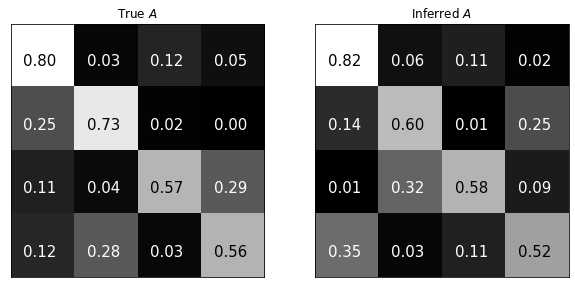

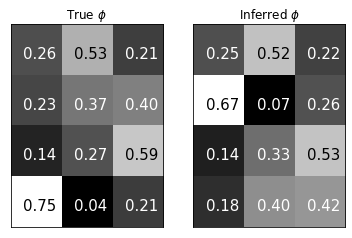

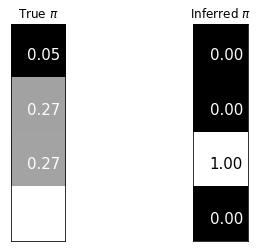

In [58]:
bestix = find_best_fit(lls_DAEM) # find the initialization that led to the best fit

# for easy comparison permute the states in order from highest to lowest self-transition probability
A_permuted, order = permute_states(A_DAEM[bestix])
A_true_permuted, order_true = permute_states(A_true)

# plot the true vs. inferred transition probabilities
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,10))
    
plot_model_params(A_true_permuted,ax[0])
plot_model_params(A_permuted, ax[1])

ax[0].set_title('True $A$')
ax[1].set_title('Inferred $A$')

# permute the observation probability matrices according to the above order
phi_permuted,_ = permute_states(phi_DAEM[bestix],method='order',param='observations',order=order)
phi_true_permuted,_ = permute_states(phi_true,method='order',param='observations',order=order_true)

# plot the true vs. inferred observation probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(phi_true_permuted,ax[0])
plot_model_params(phi_permuted, ax[1])

ax[0].set_title('True $\phi$')
ax[1].set_title('Inferred $\phi$')

# permute the initial state probability matrices according to the above order
pi_permuted,_ = permute_states(pi_DAEM[bestix,:,np.newaxis],method='order',param='observations',order=order)
pi_true_permuted,_ = permute_states(pi_true,method='order',param='observations',order=order_true)

# plot the true vs. inferred initial state probabilities
fig, ax = plt.subplots(1,2,sharey=True)
    
plot_model_params(pi_true_permuted,ax[0])
plot_model_params(pi_permuted, ax[1])

ax[0].set_title('True $\pi$')
ax[1].set_title('Inferred $\pi$')

Note that the true and inferred initial state probabilities do <i>not</i> match. This is to be expected and is a limitation of having a single time-series. Since there is only one data point (at $t=0$) from which to learn $\pi$ and it is fairly easy to determine the state at that time point (especially given a transition matrix with a strong diagonal and the same state at $t=0$ and $t=1$), the inferred initial state probabilities are likely to be close to one-hot ($1$ in one state and $0$ in the others). 

To learn the true $\pi$, therefore, it is necessary to fit multiple time-series, e.g. ones that are separated by different sessions. We cover an example of a model fit to multiple sessions in the "Real Data" section of the fit-glm-hmm.ipynb notebook but leave this demonstration here as an illustration of a model limitation related to the structure of the data.